In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab.utils.logging import ListLogger
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from tqdm import tqdm


from typing import Union
import numpy as np
import matplotlib.pyplot as plt
import torch

from typing import Tuple, Optional
import torch
from functorch import vmap


from functools import partial


import torchsde
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable


from torchdiffeq import odeint
from torch.func import jacrev


import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import ConditionalFlowMatcher
from torchcfm.models.models import *
from torchcfm.utils import *

from models.augmentation import AugmentedVectorField, CNFReg

from models.egnn import remove_mean, EGNN_dynamics

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [5]:
def get_senders_and_receivers_fully_connected(n_nodes):
    receivers = []
    senders = []
    for i in range(n_nodes):
        for j in range(n_nodes - 1):
            receivers.append(i)
            senders.append((i + 1 + j) % n_nodes)
    return torch.tensor(senders), torch.tensor(receivers)

def energy(x, epsilon= 1.0, tau= 1.0, r= 1.0, harmonic_potential_coef= 0.5):
    n_nodes, dim = x.shape
    
    if isinstance(r, float):
        r = torch.ones(n_nodes, device=device) * r
    senders, receivers = get_senders_and_receivers_fully_connected(n_nodes)
    vectors = x[senders] - x[receivers]
    d = torch.linalg.norm(vectors, ord=2, dim=-1)
    term_inside_sum = (r[receivers] / d)**12 - 2*(r[receivers] / d)**6
    energy = epsilon / (2 * tau) * term_inside_sum.sum()

    centre_of_mass = x.mean(dim=0)
    harmonic_potential = harmonic_potential_coef * (x - centre_of_mass).pow(2).sum()
    return energy + harmonic_potential


def log_prob(x: torch.Tensor):
    x = x.reshape(-1, 13, 3)
    if len(x.shape) == 2:
        return - energy(x)
    elif len(x.shape) == 3:
        return - torch.vmap(energy)(x)
    else:
        raise Exception

In [6]:
def interatomic_dist(samples):
    # Compute the pairwise differences and distances
    dist = samples[:, None, :, :] - samples[:, :, None, :]
    differences = torch.linalg.norm(dist, dim=-1)
    return differences #torch.mean(differences, dim=(1, 2))

In [7]:
def plot_sample_hist(samples, ax = None, dim=(0,1), label=None):
    if ax == None:
        fig, ax = plt.subplots()
    d = interatomic_dist(samples)
    ax.hist(d, bins=50, density=True, alpha=0.4, label=label)

### Dataset

In [8]:
from typing import NamedTuple, Optional, Union, Tuple
from pathlib import Path
class FullGraphSample(NamedTuple):
    positions: torch.Tensor
    features: torch.Tensor

    def __getitem__(self, i):
        return FullGraphSample(self.positions[i], self.features[i])


def positional_dataset_only_to_full_graph(positions) -> FullGraphSample:
    """Convert positional dataset into full graph by using zeros for features. Assumes data is only for x, and not
    augmented coordinates."""
    features = torch.zeros((*positions.shape[:-1], 1), dtype=int)
    return FullGraphSample(positions=positions, features=features)

In [9]:
def load_lj13(
    train_set_size: int = 1000, path = None
) -> Tuple[FullGraphSample, FullGraphSample, FullGraphSample]:
    # dataset from https://github.com/vgsatorras/en_flows
    # Loading following https://github.com/vgsatorras/en_flows/blob/main/dw4_experiment/dataset.py.

    # Train data
    if path is None:
        here = Path(__file__).parent
        path = here / "data"
    path = Path(path)
    fpath_train = path / "holdout_data_LJ13.npy"
    fpath_idx = path / "idx_LJ13.npy"
    fpath_val_test = path / "all_data_LJ13.npy"

    train_data = torch.tensor(np.load(fpath_train, allow_pickle=True))
    
    idxs = np.load(fpath_idx, allow_pickle=True)
    val_test_data = torch.tensor(np.load(fpath_val_test, allow_pickle=True))

    val_data = val_test_data[1000:2000]
    test_data = val_test_data[:1000]

    assert train_set_size <= len(idxs)
    train_data = train_data[idxs[:train_set_size]]
    
    val_data = np.reshape(val_data, (-1, 13, 3))
    test_data = np.reshape(test_data, (-1, 13, 3))
    train_data = np.reshape(train_data, (-1, 13, 3))
    return (
        positional_dataset_only_to_full_graph(train_data),
        positional_dataset_only_to_full_graph(val_data),
        positional_dataset_only_to_full_graph(test_data),
    )

In [40]:
# samples_all = np.load('data/all_data_LJ13-2.npy')
# test_data = samples_all[len(samples_all)//2:]
# train_data = samples_all[:len(samples_all)//2]


n_nodes = 13
dim = 3

test_data = np.load('data/all_data_LJ13.npy')[:1000]
train_data = np.load('data/holdout_data_LJ13.npy')

# test_data = remove_mean(test_data, n_nodes, dim)
# train_data = remove_mean(train_data, n_nodes, dim)

train_data = torch.tensor(train_data, device="cpu")
test_data = torch.tensor(test_data, device="cpu")

In [41]:
test_dists = interatomic_dist(test_data.reshape(-1, n_nodes, dim))

### Model

In [42]:
from egnn_pytorch import EGNN_Network
class EGNN_Wrapper(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EGNN_Network(
            *args, **kwargs
        )

    def forward(self, x, t, *args, **kwargs):
        is_flat = x.shape[-1] != 3
        if is_flat:
            x = x.reshape(-1, 13, 3)
        if t.dim() == 0:
            t = t[None].repeat(x.shape[0])
        if t.shape[0] != x.shape[0] and t.shape[0] == 1:
            t = t.repeat(x.shape[0])
        t_discrete = torch.bucketize(t, boundaries = torch.linspace(0, 1, 101).to(device))
        t_discrete = t_discrete[:, None].repeat(1, 13) #
        x = x - x.mean(dim=-2, keepdims=True)
        feats, coords = self.net(t_discrete, x)
        # coords = coords / coords.mean(dim=-2, keepdims=True)
        if is_flat:
            coords = coords.reshape(-1, 39)
        
        return coords

### Helpers

In [51]:
def sample_centered_gaussian(shape):
    samples = torch.randn(shape)
    samples = samples - samples.mean(-2, keepdims=True)
    return samples
def sample_data(data, batch_size):
    idx = torch.randint(0,8000, (batch_size, ))
    return data[idx].positions

In [52]:
def center_gravity_zero_gaussian_log_likelihood(x):
    N, D = x.shape[-2:]

    # r is invariant to a basis change in the relevant hyperplane.
    r2 = torch.sum(x**2, dim=(-1, -2))

    # The relevant hyperplane is (N-1) * D dimensional.
    degrees_of_freedom = (N-1) * D

    # Normalizing constant and logpx are computed:
    log_normalizing_constant = -0.5 * degrees_of_freedom * math.log(2*torch.pi)
    log_px = -0.5 * r2 + log_normalizing_constant

    return log_px

In [53]:
def cfm_inference(model, xt, t, dt):
    with torch.no_grad():
        vt = model(t, xt)
        xt_new = xt + vt * dt
        return xt_new

In [54]:
def generate_samples_ode(model, x_init, t_span, dt):
    times = torch.arange(t_span[0], t_span[1], dt)
    samples = []
    x = x_init
    with torch.no_grad():
        for t in times:
            x = cfm_inference(model, x, t, 1e-3)
            samples.append(x)
    return torch.stack(samples)

### CFM Training 

In [58]:
sigma = 0.0
batch_size = 256
model = EGNN_dynamics(n_particles=n_nodes, device="cpu",  n_dimension=dim, hidden_nf=32, 
                      act_fn=torch.nn.SiLU(), n_layers=3, recurrent=True, tanh=True, attention=True, condition_time=True, agg='sum')


amodel = AugmentedVectorField(model, [CNFReg("exact")], dim=(13, 3))
node = NeuralODE(amodel, solver="euler")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [59]:
FM = ConditionalFlowMatcher(sigma=sigma)

In [63]:
def cfm_loss(model, x1):
    x1 = x1.reshape(-1, 13, 3)
    x0 = sample_centered_gaussian((x1.shape[0], 13, 3))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
    xt = xt.reshape(-1, 39)
    ut = ut.reshape(-1, 39)

    # xt_centered = xt - xt.mean(dim=-2, keepdims=True)

    vt = model(t[:, None], xt)
    loss = torch.mean((vt - ut) ** 2)
    return loss

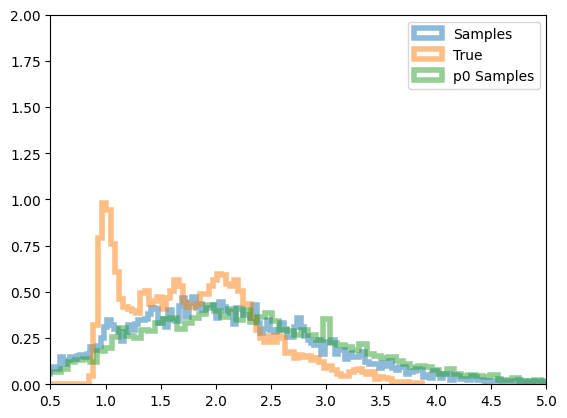

torch.Size([10, 13, 3])
0 tensor(44.3100) tensor(39.9209)


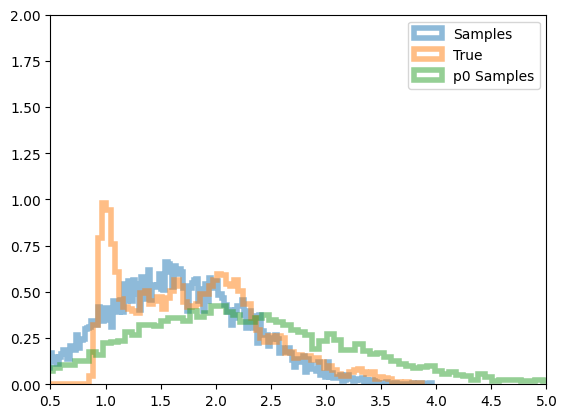

torch.Size([10, 13, 3])
100 tensor(42.8614) tensor(35.3077)


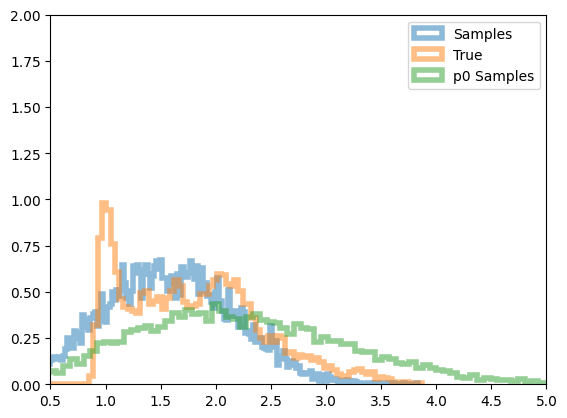

torch.Size([10, 13, 3])
200 tensor(42.8288) tensor(33.4882)


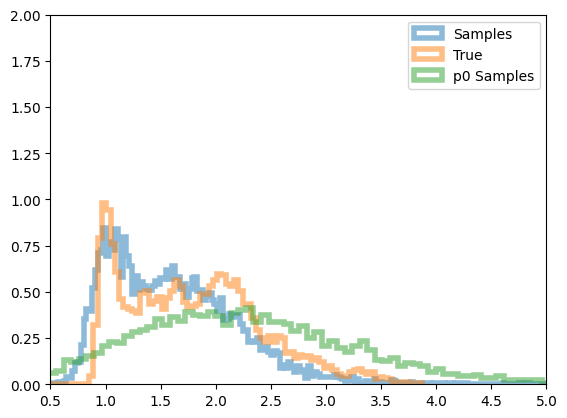

torch.Size([10, 13, 3])
300 tensor(35.3781) tensor(23.0680)


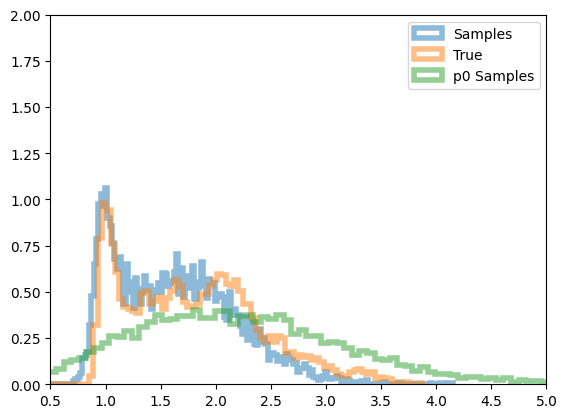

torch.Size([10, 13, 3])
400 tensor(31.4393) tensor(17.7098)


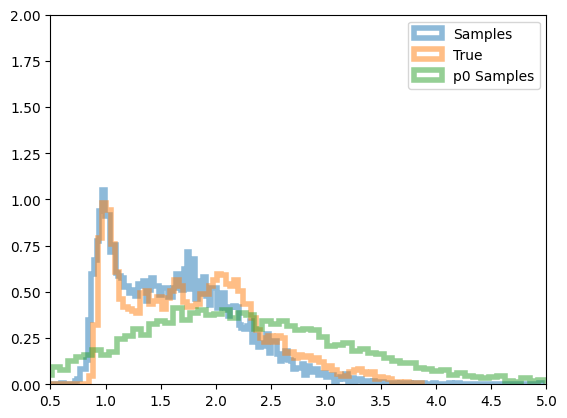

torch.Size([10, 13, 3])
500 tensor(31.3929) tensor(15.6395)


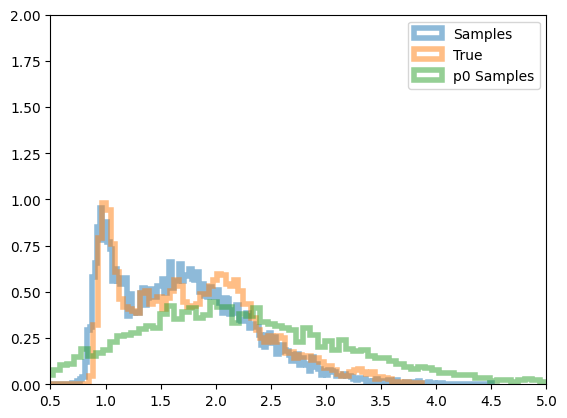

KeyboardInterrupt: 

In [64]:
start = time.time()
for k in range(30000):
    optimizer.zero_grad()

    # x0 = torch.randn(batch_size, n_nodes*dim) * 10
    # perm = torch.randperm(test_data.shape[0])
    # idx = perm[:batch_size]
    # x1 = test_data[idx].cpu()


    # x0 = sample_centered_gaussian((batch_size, 13, 3))
    # # x1 = sample_data(train_data, batch_size)
    perm = torch.randperm(train_data.shape[0])
    idx = perm[:batch_size]
    x1 = train_data[idx].reshape(-1, 13, 3)

    # t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    # xt = xt.reshape(-1, 39)
    # ut = ut.reshape(-1, 39)

    # vt = model(t[:, None], xt)
    # loss = torch.mean((vt - ut) ** 2)

    loss = cfm_loss(model, x1)

    loss.backward()
    optimizer.step()

    if k % 100 == 0:
        x1_samples_cfm = sample_centered_gaussian((100, n_nodes, dim)).reshape(-1, 39)
        samples = generate_samples_ode(model, x1_samples_cfm, [0, 1], 1e-3)[-1]
        samples_energy = log_prob(samples.to(device)).detach()
        dist_samples = interatomic_dist(samples.reshape(-1, n_nodes, dim))
        dist_x1 = interatomic_dist(x1_samples_cfm.reshape(-1, n_nodes, dim))
        plt.hist(dist_samples.view(-1).detach().cpu().numpy(), bins=200, alpha=0.5, density=True, histtype='step', linewidth=4, label='Samples')
        plt.hist(test_dists.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4, label='True')
        plt.hist(dist_x1.view(-1).detach().cpu().numpy(), bins=100, alpha=0.5, density=True, histtype='step', linewidth=4, label='p0 Samples')
        plt.xlim(0.5, 5)
        plt.ylim(0, 2)
        plt.legend()
        plt.show()


        with torch.no_grad():
            x0 = node.trajectory(torch.cat([torch.zeros((1000, 1)), test_data[:1000].reshape(-1, 39)], dim=1)[:10], t_span = torch.linspace(1, 0, 21))
            # x0 = node.trajectory(torch.cat([torch.zeros((1000, 1)), test_data.positions.reshape(-1, 39).cpu()], dim=1)[:10], t_span = torch.linspace(1, 0, 21))
            # this is probably wrong, using nll from Gaussian
            x0_centered = x0[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            
            nll = -(center_gravity_zero_gaussian_log_likelihood(x0_centered) - x0[-1,:, 0])

            # x0_train = node.trajectory(torch.cat([torch.zeros((1000, 1)), train_data.positions[:1000].reshape(-1, 39).cpu()], dim=1)[:10], t_span = torch.linspace(1, 0, 21))
            x0_train = node.trajectory(torch.cat([torch.zeros((1000, 1)), train_data[:1000].reshape(-1, 39)], dim=1)[:10], t_span = torch.linspace(1, 0, 21))
            x0_centered = x0_train[-1, :, 1:]
            x0_centered = x0_centered.reshape(-1, 13, 3)
            x0_centered = x0_centered - x0_centered.mean(dim=-2, keepdims=True)
            print(x0_centered.shape)
            nll_train = -(center_gravity_zero_gaussian_log_likelihood(x0_centered) - x0_train[-1,:, 0])
            print(k, nll.mean(), nll_train.mean())